In [1]:
from jupyter_imports import *
from copy import deepcopy

In [2]:
# run only once
from utils.MyLogger import ExecutionLogger # use 'prod' for remote after cache_tmp
start = datetime(2022,7,13,18)#,tzinfo=timezone.utc)
dirname = os.path.join(os.sep, 'tmp','prod','tradeexecutor')#,'prod')
ExecutionLogger.batch_summarize_exec_logs(dirname=dirname,start=start,add_history_context=False,rebuild=True)

'moved 0 logs to unreadable'

In [3]:
files = ['all_by_clientOrderId','all_by_coin','all_by_symbol','all_parameters','all_request','all_data']
original = {file:pd.read_csv(os.path.join(os.sep, dirname,f'{file}.csv'),parse_dates=['log_time'],index_col=0) for file in files}

In [4]:
cmap = cm.get_cmap('Spectral')
#fig, ax = plt.subplots(1)

## parameters for reference

In [5]:
all_parameters = original['all_parameters']
all_parameters = all_parameters[all_parameters['index']!='inception_time']
all_parameters['hash'] = all_parameters['log_time'].apply(lambda x: pd.util.hash_pandas_object(all_parameters.groupby('log_time').get_group(x).astype(str)).sum())
all_parameters['param_index'] = all_parameters['hash'].apply(lambda h: list(all_parameters['hash'].unique()).index(h))
all_parameters.drop(columns=['hash'],inplace=True)
param_map = all_parameters.set_index('log_time')['param_index'].to_dict()
param_map

{Timestamp('2022-07-14 15:50:37.877480+0000', tz='UTC'): 0,
 Timestamp('2022-07-14 15:00:25.164632+0000', tz='UTC'): 1,
 Timestamp('2022-07-14 15:51:29.415000+0000', tz='UTC'): 2}

In [6]:
indexed = deepcopy(original)
for df in indexed.values():
    df['param_index'] = df['log_time'].apply(lambda x:param_map[x])
#colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(all_parameters['param_index'].unique())))

### slippage, fees in bps. filled in USD

In [7]:
indexed['all_data'].columns

Index(['index', 'clientOrderId', 'eventID', 'lifecycle_state',
       'remote_timestamp', 'timestamp', 'id', 'symbol', 'type', 'side',
       'amount', 'remaining', 'price', 'comment', 'risk_timestamp', 'delta',
       'netDelta', 'pv(wrong timestamp)', 'margin_headroom', 'IM_discrepancy',
       'mkt_timestamp', 'bid', 'bidVolume', 'ask', 'askVolume', 'info',
       'datetime', 'lastTradeTimestamp', 'timeInForce', 'postOnly',
       'reduceOnly', 'stopPrice', 'cost', 'average', 'filled', 'status', 'fee',
       'trades', 'fees', 'order', 'takerOrMaker', 'fillId', 'log_time',
       'orderTrigger', 'param_index'],
      dtype='object')

In [8]:
by_symbol = indexed['all_by_symbol']
by_symbol = by_symbol[by_symbol['log_time']>start.replace(tzinfo=timezone.utc)]
by_symbol['absFilled'] = by_symbol['filledUSD'].apply(np.abs)
by_symbol['total_bps'] = by_symbol['slippage_bps'] + by_symbol['fee']
by_symbol['fee_USD'] = by_symbol['fee']*by_symbol['absFilled']/10000 # in bps for by_symbol, in USD for by_clientorderid :(
by_symbol['slippage_USD'] = by_symbol['slippage_bps']*by_symbol['absFilled']/10000
by_symbol['total_USD'] = by_symbol['total_bps']*by_symbol['absFilled']/10000

In [9]:
df_symbol = by_symbol[by_symbol['index']=='average'].pivot_table(index='log_time',aggfunc=sum)
df_symbol[['fee_USD','slippage_USD','total_USD']] /= 10000*by_symbol[by_symbol['index']=='average'].pivot_table(index='log_time',values=['absFilled'],aggfunc=sum).values

<AxesSubplot:xlabel='log_time'>

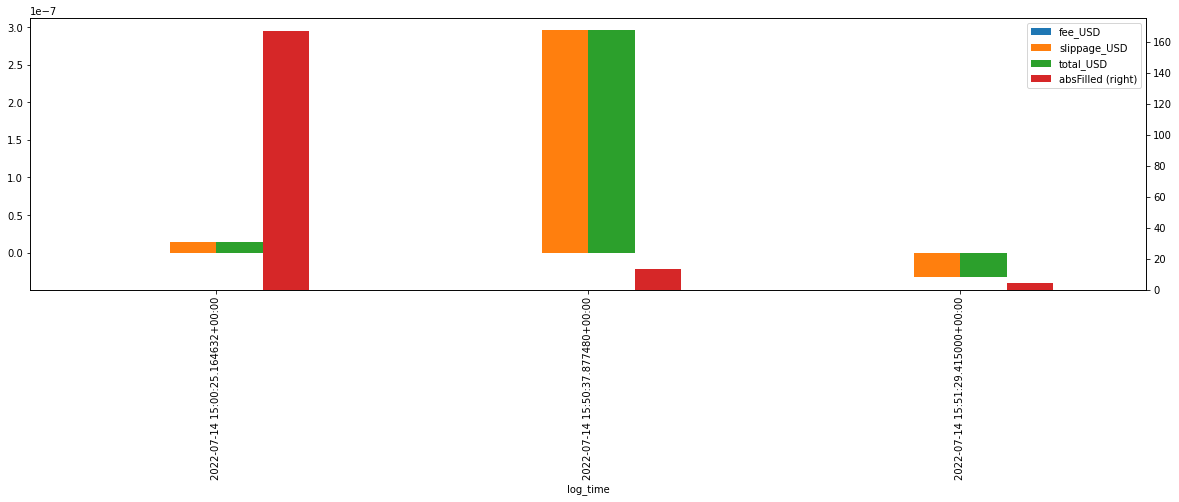

In [10]:
#ax.plot(df, c=df['param_index'], s=120, cmap=cmap, edgecolor='None',figsize=(20,10))
#plt.show()
df_symbol[['fee_USD','slippage_USD','total_USD','absFilled']].plot.bar(secondary_y='absFilled',figsize=(20,5))

### slippage distribution

       total_bps  fee
count   7.000000  7.0
mean    8.117023  0.0
std    15.521092  0.0
min    -6.582064  0.0
25%    -3.263761  0.0
50%     1.381202  0.0
75%    19.471330  0.0
max    29.604887  0.0


<AxesSubplot:>

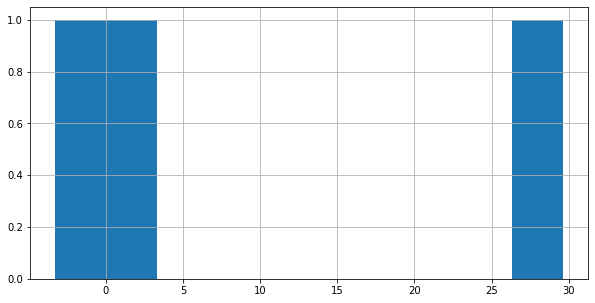

In [11]:
print(by_symbol[['total_bps','fee']].describe())
by_symbol.loc[by_symbol['index']=='average','total_bps'].hist(figsize=(10,5))

<AxesSubplot:xlabel='log_time'>

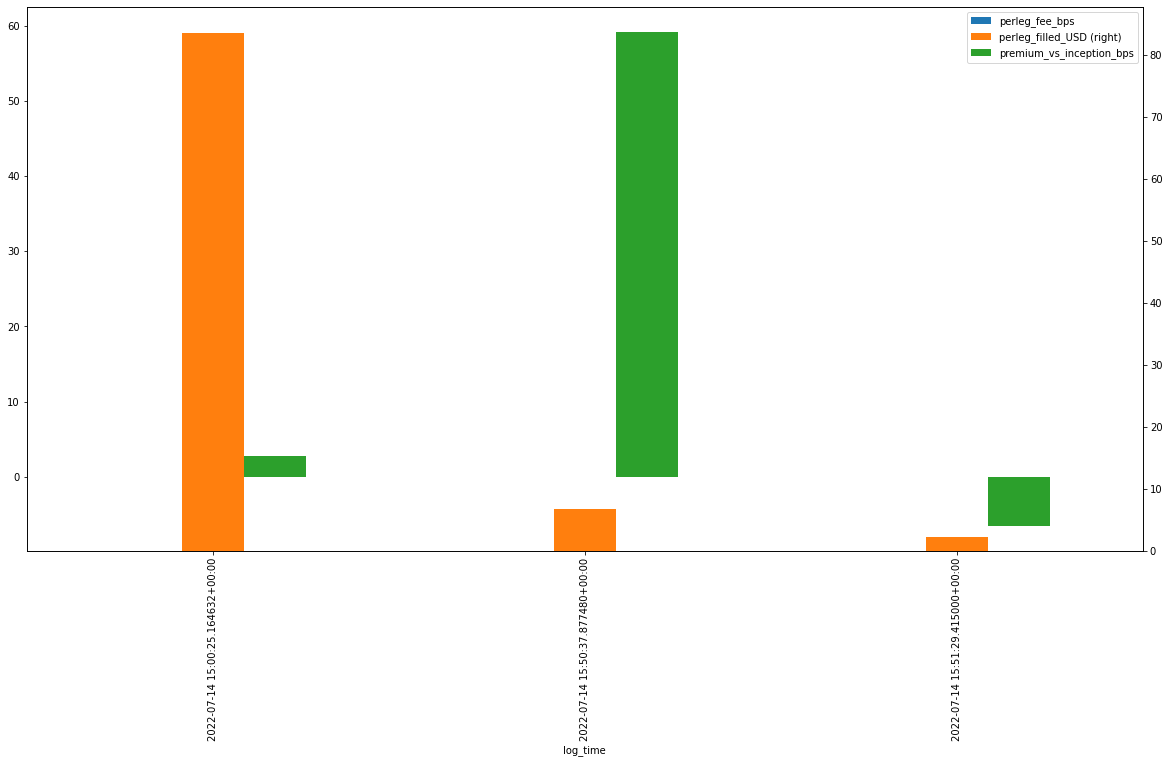

In [12]:
by_coin = indexed['all_by_coin']
trackrecord = by_coin[by_coin['index']=='average'].pivot_table(index='log_time',values=['perleg_fee_bps','perleg_filled_USD','premium_vs_inception_bps'],aggfunc=np.mean)
trackrecord.plot.bar(secondary_y='perleg_filled_USD',figsize=(20,10))

# tick to ack

,pending_to_ack_local
count,7.000000
mean,109.952148
std,14.567682
min,97.247070
25%,97.915527
50%,108.751953
75%,116.431396
max,134.972168


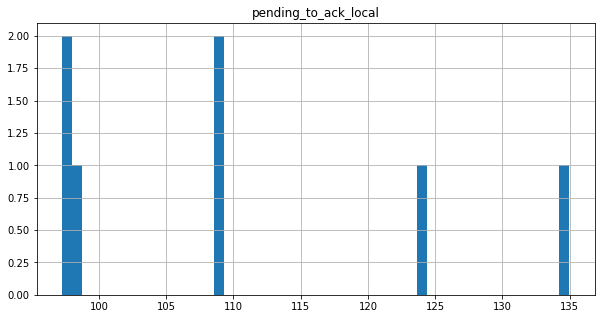

In [13]:
by_clientOrderId = indexed['all_by_clientOrderId']
tick_to_order_local = by_clientOrderId[['pending_to_ack_local']]
tick_to_order_local.hist(bins=50,figsize=(10,5))
tick_to_order_local.describe()

# remote vs local (~ round trip)

,round_trip
count,34.000000
mean,178.311552
std,757.191092
min,0.025879
25%,29.164429
50%,33.114014
75%,62.308960
max,4456.817871


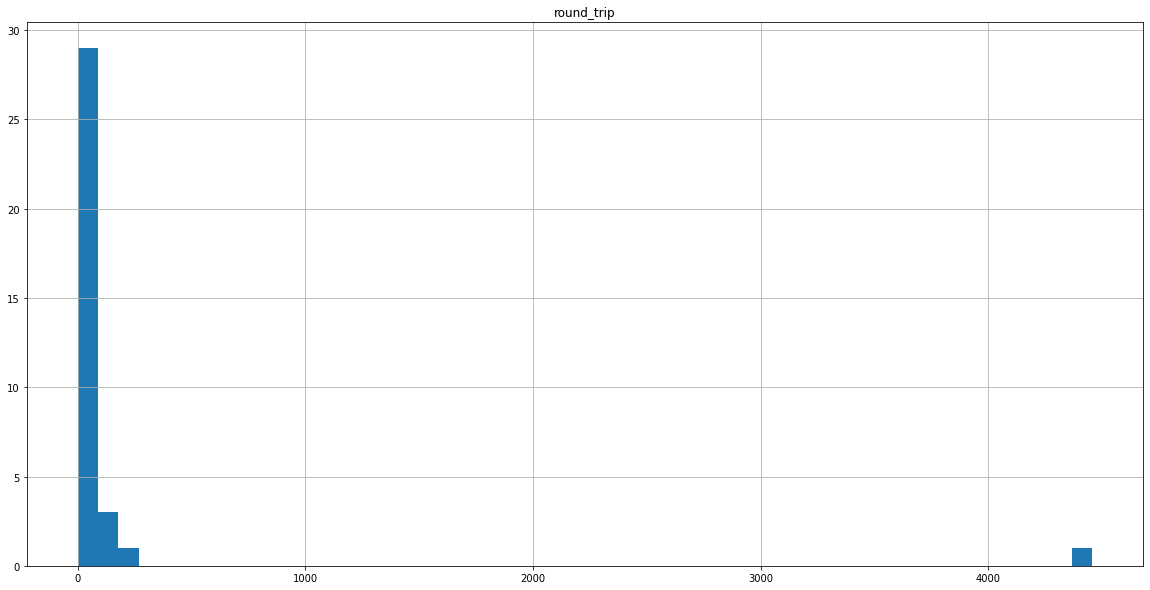

In [14]:
round_trip = pd.DataFrame(columns=['round_trip'], data = 2*(indexed['all_data']['timestamp']-indexed['all_data']['remote_timestamp']))
round_trip.hist(bins=50,figsize=(20,10))
round_trip.describe()